In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

In [26]:
df = pd.read_csv('advertising_data_new.csv')
df.head()

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,219687,interest,150000,0.0,Android,banner,0.5
1,143856,interest,150000,0.0,Android,organic_traffic,0.0
2,26717,consideration,150000,0.0,Android,organic_traffic,0.0
3,991236,interest,150000,0.0,Android,native,2.0
4,387356,interest,150000,0.0,iOS,search,1.5


In [27]:
# Сохраняем органический трафик в отдельный датафрейм
organic_df = df.loc[df['ad_channel'] == 'organic_traffic']
org_funnel = organic_df.groupby(['funnel_stage']).agg({'user_id': 'count'}).sort_values('user_id', ascending=False).reset_index()
# Добавляем столбец с процентом от общего количества пользователей
org_funnel['percent'] = round(org_funnel['user_id'] / org_funnel['user_id'].max() * 100, 1)
org_funnel

,funnel_stage,user_id,percent
0,interest,78065,100.0
1,consideration,53592,68.7
2,intent,9095,11.7
3,purchase,542,0.7


In [28]:
# Сохраняем платный трафик в отдельный датафрейм
advertising_df = df.loc[df['ad_channel'] != 'organic_traffic']
adv_funnel = advertising_df.groupby(['funnel_stage']).agg({'user_id': 'count'}).sort_values('user_id', ascending=False).reset_index()
# Добавляем столбец с процентом от общего количества пользователей
adv_funnel['percent'] = round(adv_funnel['user_id'] / adv_funnel['user_id'].max() * 100, 1)
adv_funnel

,funnel_stage,user_id,percent
0,interest,505047,100.0
1,consideration,284695,56.4
2,intent,40884,8.1
3,purchase,4292,0.8


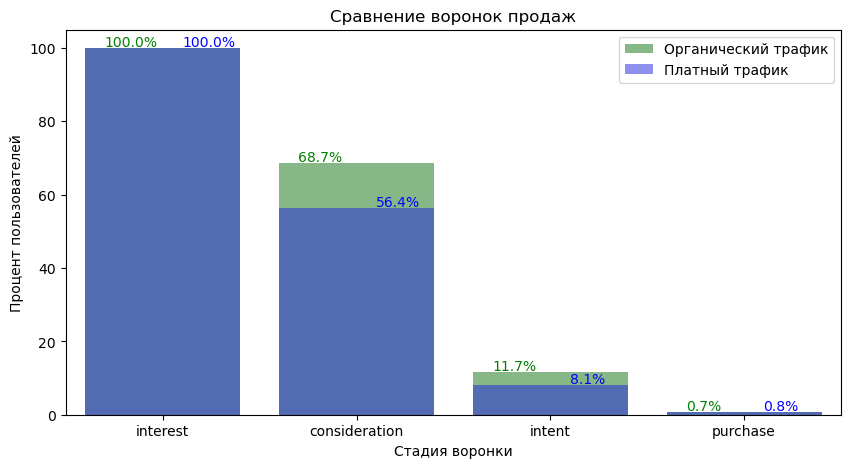

In [29]:
# Строим график для сравнения воронок
plt.figure(figsize=(10, 5))
sns.barplot(x='funnel_stage', y='percent', data=org_funnel, color='green', alpha=0.5, label='Органический трафик')
sns.barplot(x='funnel_stage', y='percent', data=adv_funnel, color='blue', alpha=0.5, label='Платный трафик')
plt.title('Сравнение воронок продаж')
plt.xlabel('Стадия воронки')
plt.ylabel('Процент пользователей')
plt.legend()
# Добавляем подписи к столбцам
for i in range(len(org_funnel)):
    plt.text(x=i-0.3, y=org_funnel['percent'][i]+0.5, s=f"{org_funnel['percent'][i]}%", color='green')
for i in range(len(adv_funnel)):
    plt.text(x=i+0.1, y=adv_funnel['percent'][i]+0.5, s=f"{adv_funnel['percent'][i]}%", color='blue')
plt.show()

In [30]:
# Проверяем гипотезу о том, что конверсия в покупку одинакова для органического и платного трафика
# H0: конверсия в покупку одинакова для органического и платного трафика
# H1: конверсия в покупку различается для органического и платного трафика
# Уровень значимости 5%
# Критическая область двухсторонняя

# Создаём две переменные, в которые сохраняем количество пользователей на каждом этапе воронки
adv_count = adv_funnel.user_id.values[1:4]
org_count = org_funnel.user_id.values[1:4]
nobs = adv_funnel.user_id[0], org_funnel.user_id[0]

# Проводим ztest на равенство долей для каждого этапа воронки
for adv, org in zip(adv_count, org_count):
    count = adv, org
    stat, p_value = proportions_ztest(count, nobs)
    nobs = count
    print(f'stat = {stat}, p_value = {p_value}')
# Вывод: p_value < 0.05, поэтому мы отвергаем нулевую гипотезу о равенстве конверсии в покупку для органического и платного трафика

stat = -64.70159087700598, p_value = 0.0
stat = -15.621823119499396, p_value = 5.1705786428090794e-55
stat = 13.244722205622812, p_value = 4.840696387617436e-40


In [31]:
# Заменяем названия этапов воронки на числа для удобства
df['funnel_stage'] = df['funnel_stage'].map({'interest': 1, 'consideration': 2, 'intent': 3, 'purchase': 4})

In [32]:
# Считаем количество пользователей на каждом этапе воронки для каждого канала
funnel_by_channel = df.groupby(['ad_channel', 'funnel_stage']).agg({'user_id': 'count'}).reset_index()
# Считаем процент пользователей на каждом этапе воронки для каждого канала
funnel_by_channel['percent_by_channel'] = round(funnel_by_channel['user_id'] / funnel_by_channel.groupby('ad_channel')['user_id'].transform('max') * 100, 2)
# Считаем процент пользователей на каждом этапе воронки от общего числа пользователей для каждого канала
funnel_by_channel['percent_total'] = round(funnel_by_channel['user_id'] / len(df) * 100, 4)
funnel_by_channel

,ad_channel,funnel_stage,user_id,percent_by_channel,percent_total
0,banner,1,91282,100.00,9.3506
1,banner,2,47540,52.08,4.8698
2,banner,3,7566,8.29,0.7750
3,banner,4,688,0.75,0.0705
4,native,1,19229,100.00,1.9698
5,native,2,12597,65.51,1.2904
6,native,3,409,2.13,0.0419
7,native,4,37,0.19,0.0038
8,organic_traffic,1,78065,100.00,7.9967
9,organic_traffic,2,53592,68.65,5.4898


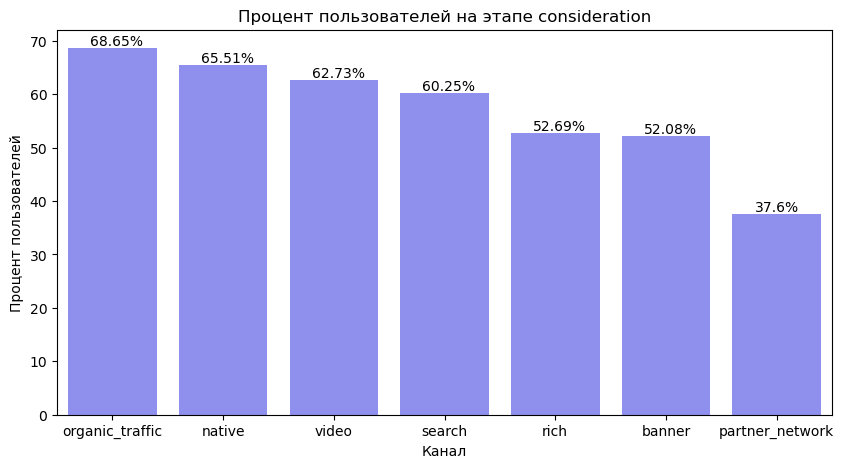

In [33]:
# Строим сводную таблицу, где значения - процент пользователей на каждом этапе воронки для каждого канала
funnel_by_channel_pivot = funnel_by_channel.pivot(index='ad_channel', columns='funnel_stage', values='percent_by_channel')
# Сортируем по убыванию процента пользователей на этапе consideration
funnel_by_channel_pivot = funnel_by_channel_pivot.sort_values(2, ascending=False)

# Строим график для 2 этапа воронки
plt.figure(figsize=(10, 5))
sns.barplot(x=funnel_by_channel_pivot.index, y=funnel_by_channel_pivot[2], color='blue', alpha=0.5)
plt.title('Процент пользователей на этапе consideration')
plt.xlabel('Канал')
plt.ylabel('Процент пользователей')
# Добавляем подписи к столбцам
for i in range(len(funnel_by_channel_pivot)):
    plt.text(x=i-0.2, y=funnel_by_channel_pivot[2][i]+0.5, s=f"{funnel_by_channel_pivot[2][i]}%")
plt.show()

##### Лучшие: organic_traffic - 68.65% и native - 65.51% #
##### Худший: partner_network - 37.6% #

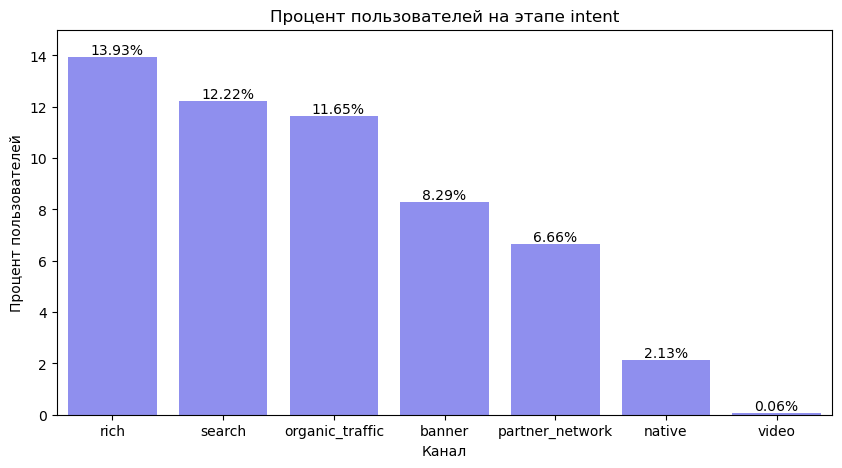

In [34]:
# Сортируем по убыванию процента пользователей на этапе intent
funnel_by_channel_pivot = funnel_by_channel_pivot.sort_values(3, ascending=False)

# Строим график для 3 этапа воронки
plt.figure(figsize=(10, 5))
sns.barplot(x=funnel_by_channel_pivot.index, y=funnel_by_channel_pivot[3], color='blue', alpha=0.5)
plt.title('Процент пользователей на этапе intent')
plt.xlabel('Канал')
plt.ylabel('Процент пользователей')
plt.ylim(0, 15)
# Добавляем подписи к столбцам
for i in range(len(funnel_by_channel_pivot)):
    plt.text(x=i-0.2, y=funnel_by_channel_pivot[3][i]+0.1, s=f"{funnel_by_channel_pivot[3][i]}%")
plt.show()

##### Лучший: rich - 13.93% #
##### Худший: video - 0.06% #

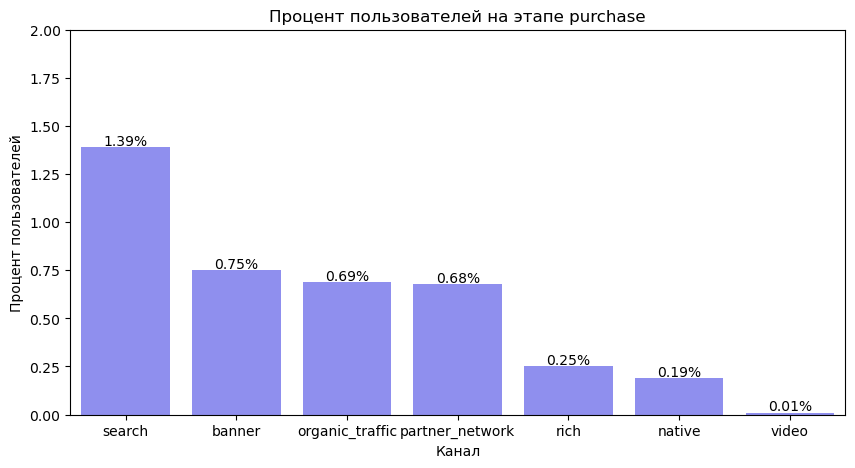

In [35]:
# Сортируем по убыванию процента пользователей на этапе purchase
funnel_by_channel_pivot = funnel_by_channel_pivot.sort_values(4, ascending=False)

# Строим график для 4 этапа воронки
plt.figure(figsize=(10, 5))
sns.barplot(x=funnel_by_channel_pivot.index, y=funnel_by_channel_pivot[4], color='blue', alpha=0.5)
plt.title('Процент пользователей на этапе purchase')
plt.xlabel('Канал')
plt.ylabel('Процент пользователей')
plt.ylim(0, 2)
# Добавляем подписи к столбцам
for i in range(len(funnel_by_channel_pivot)):
    plt.text(x=i-0.2, y=funnel_by_channel_pivot[4][i]+0.01, s=f"{funnel_by_channel_pivot[4][i]}%")
plt.show()

##### Лучший: search - 1.39% #
##### Худший: video - 0.01% #


Основываясь на наблюдениях, мы можем предположить, что канал video является наименее эффективным каналом и его следует отключить. Он имеет низкую конверсию на 3 и 4 этапах воронки, что указывает на его малую эффективность в привлечении пользователей. Его отключение позволит перераспределить показы по другим каналам, что потенциально увеличит продажи.

Канал search является идеальным выбором для перераспределения показов, ведь он проявляет несомненные преимущества. Он постоянно демонстрирует высокую конверсию на каждом этапе воронки продаж. Особенно впечатляющие результаты он достигает на финальном этапе - конверсия в покупку вдвое превышает результаты ближайшего конкурента.